In [147]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_loader.data_loader import PhageLoader
from torch.utils.data.sampler import SubsetRandomSampler
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [64]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_labels, number_of_layers=1, bidirectional=True, weights_matrix=None):
        super(GRU, self).__init__()
        
        self.bidirectional = bidirectional
        self.hidden_dim_dense = hidden_size
        self.num_layers = number_of_layers 
        if bidirectional:
            self.hidden_dim_dense = hidden_size * 2
        if len(weights_matrix.size())!=0:
            self.emb_layer = self.create_emb_layer(weights_matrix)          
        else:
            self.emb_layer = nn.Embedding(vocab_size, embedding_size)
            
        self.gru = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, bidirectional=bidirectional, num_layers=number_of_layers,batch_first=True)
        self.linear = nn.Linear(self.hidden_dim_dense, int(self.hidden_dim_dense/2))
        self.linear2 = nn.Linear(int(self.hidden_dim_dense/2),output_labels)
        
    def forward(self, h_t1, indexes):
        #indexes -> (batch,seq_length)
        embedding = self.emb_layer(indexes)
        #print("EMBEDDING SHAPE: ", embedding.size())
        #embedding -> (batch,seq_length,embedding_size)
        out,h_t = self.gru(embedding, h_t1)
        #print("OUT SHAPE: ", out.size(), self.hidden_dim_dense)
        #out -> ()
        #out = out.view(self.hidden_dim_dense, -1)
        
        out = F.relu(self.linear(out))
        out = self.linear2(out)
        out = F.log_softmax(out,dim=2)
        
        return out,h_t
        
    def initHidden(self, batch_size, hidden_size):
        if self.bidirectional:
            return torch.randn(self.num_layers*2, batch_size, hidden_size, device=device)
        else:
            return torch.randn(self.num_layers, batch_size, hidden_size, device=device)

    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.size()
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        if non_trainable:
            emb_layer.weight.requires_grad = False
        return emb_layer
    
    

In [65]:
loader = PhageLoader("data/")
read_length = 100

In [28]:
k_size=1
batch_size = 30
read_length = 100
dataset = loader.get_data_set(n_files='all',read_length=read_length, batch_size=batch_size, k=k_size, stride=1, embedding="dict", embed_size=None, drop_last=False)


In [66]:
def split_sets(dataset):
    n = len(dataset)  # how many total elements you have
    test_size = .1
    n_test = int( n * test_size )  # number of test/val elements
    n_train = n - 2 * n_test

    idx = list(range(n))  # indices to all elements
    np.random.shuffle(idx)  # in-place shuffle the indices to facilitate random splitting
    train_idx = idx[:n_train]
    val_idx = idx[n_train:(n_train + n_test)]
    test_idx = idx[(n_train + n_test):]

    print(n,len(train_idx),len(val_idx),len(test_idx))
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler,drop_last=True)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler,drop_last=True)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler,drop_last=True)
    return train_loader, validation_loader, test_loader


In [67]:
def get_initial_embeddings(k=3):
    if(k<=2):
        return torch.from_numpy(np.eye(4**k))
    dictionary = loader.get_dict(k,'dna2vec')
    indexes = loader.get_dict(k)
    size = len(indexes)
    matrix = np.zeros((size,100))
    for key, value in indexes.items():
        matrix[value] = dictionary[key]
    return torch.from_numpy(matrix)

In [68]:
def check_gradients(model):
    gru = model.gru
    for p,n in zip(gru.parameters(),gru._all_weights[0]):
        if n[:6] == 'weight':
            print('===========\ngradient:{}\n----------\n{}'.format(n,p.grad.abs().sum()))

In [69]:
def accuracy_test(loader,model,hidden):
    total = 0
    correct = 0
    with torch.no_grad():
       
        for b, (x, y) in enumerate(loader):
            x = x.type(torch.LongTensor)
            y = y.type(torch.LongTensor)
            out,hidden = model(hidden,x)
            y = y.view(batch_size*read_length)
            out = out.view(batch_size*read_length,output_labels).exp()
            _, out_index= torch.max(out,dim=-1)
            #print(out_index)
            correct += (out_index.eq(y)).sum()
            total += len(y)
    return correct.item()/total

In [ ]:
vocab_size = 4**k_size
embedding_layer_size = 4
hidden_size = 30
output_labels=2
initial_embedding = get_initial_embeddings(k_size)
model = GRU(vocab_size, embedding_layer_size, hidden_size, output_labels,weights_matrix=initial_embedding)
model.to(device)
weights = torch.tensor([8,1],dtype=torch.float)
weights.to(device)
val_accuracies = []
train_accuracies = []

hidden = model.initHidden(batch_size,hidden_size)
loss_function = nn.NLLLoss(weight = weights)
optimizer = optim.SGD(model.parameters(), lr=0.09)

losses = []
running_loss = 0
epochs = 40

train_loader, validation_loader, test_loader = split_sets(dataset)

for epoch in range(epochs):
    for b, (x, y) in enumerate(train_loader):
        #gives batches of size "batch_size, read_length"
        model.zero_grad()
        x, y = x.to(device), y.to(device)
        x = x.type(torch.LongTensor)
        y = y.type(torch.LongTensor)
            
        out,hidden = model(hidden,x)
        y = y.view(batch_size*read_length)
        out = out.view(batch_size*read_length,output_labels)
        loss = loss_function(out,y)
        running_loss = running_loss + loss.item()
        
        
        loss.backward()
        optimizer.step()
        
        if b % 20 == 19:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, b + 1, running_loss / 100))
            #losses.append(running_loss)
            #running_loss = 0.0
            check_gradients(model)
            
        hidden.detach_()
    train_acc = accuracy_test(train_loader,model,hidden)
    val_acc = accuracy_test(validation_loader,model,hidden)
    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)
    losses.append(running_loss)
    running_loss = 0.0

87458 69968 8745 8745
[1,    20] loss: 0.136
gradient:weight_ih_l0
----------
0.08361350744962692
gradient:weight_hh_l0
----------
0.12927617132663727
[1,    40] loss: 0.275
gradient:weight_ih_l0
----------
0.022462794557213783
gradient:weight_hh_l0
----------
0.01673997938632965
[1,    60] loss: 0.414
gradient:weight_ih_l0
----------
0.08799241483211517
gradient:weight_hh_l0
----------
0.13606303930282593
[1,    80] loss: 0.552
gradient:weight_ih_l0
----------
0.05407660827040672
gradient:weight_hh_l0
----------
0.07342848181724548
[1,   100] loss: 0.692
gradient:weight_ih_l0
----------
0.20722444355487823
gradient:weight_hh_l0
----------
0.3186614215373993
[1,   120] loss: 0.830
gradient:weight_ih_l0
----------
0.0906217023730278
gradient:weight_hh_l0
----------
0.1416458934545517
[1,   140] loss: 0.969
gradient:weight_ih_l0
----------
0.23179075121879578
gradient:weight_hh_l0
----------
0.3565121591091156
[1,   160] loss: 1.108
gradient:weight_ih_l0
----------
0.05126934126019478
gr

In [72]:
losses

[1615.7679592967033,
 1614.7401441931725,
 1613.4850549697876,
 1612.1008058786392,
 1611.594038784504,
 1609.886424601078,
 1607.1085419654846,
 1604.278683423996,
 1600.3517803549767,
 1598.808799982071,
 1598.066387474537,
 1593.0169615149498,
 1588.4210968017578,
 1587.5487075448036,
 1583.8351075649261]

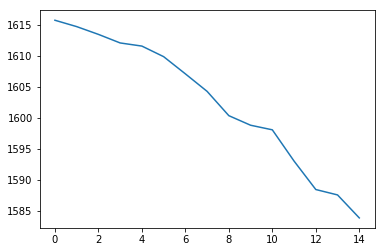

In [76]:
plt.plot(losses)

In [48]:
dataset

In [88]:
np.ndarray(0)

array([], dtype=float64)

In [114]:
def strip_plot(model,loader,hidden):
    total = 0
    correct = 0
    with torch.no_grad():
        bs = []
        outs = []
        ys = []
        for b, (x, y) in enumerate(loader):
            x = x.type(torch.LongTensor)
            y = y.type(torch.LongTensor)
            out, _  = model(hidden,x)
            y = y.view(batch_size*read_length)
            out = out.view(batch_size*read_length,output_labels).exp()
            _, out_index= torch.max(out,dim=-1)
            bs.append(np.ones(y.shape[0])*b)
            outs.append(out_index.numpy())
            ys.append(y.numpy())
            
            print(b)
    return pd.DataFrame({"batch": np.concatenate(bs), "predicted": np.concatenate(outs),"actual": np.concatenate(ys)})

In [115]:
dataframe = strip_plot(model,test_loader,hidden)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

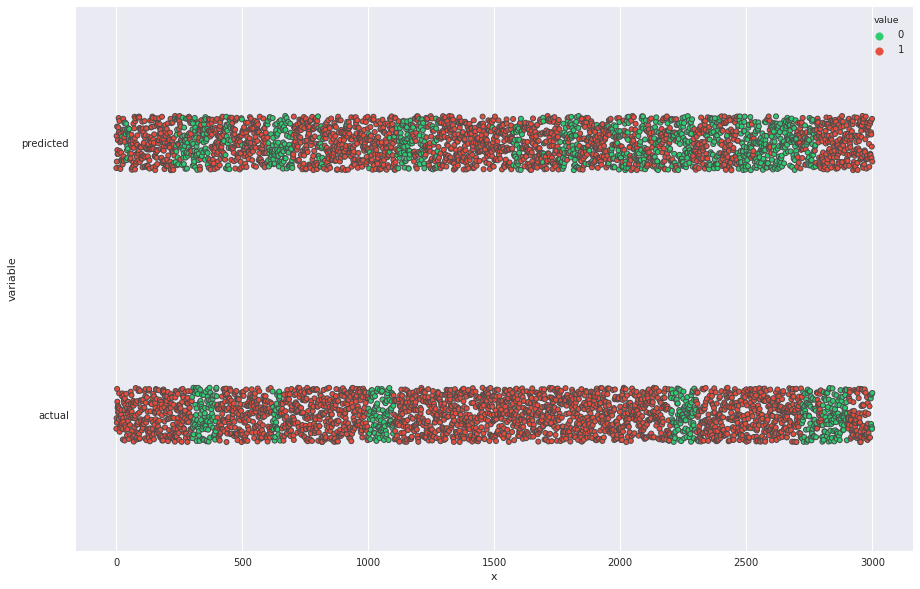

In [146]:
df1 = dataframe[dataframe['batch'] == 1]
#ax = sns.stripplot(x="total_bill", y="day", data=tips)

df = pd.melt(df1, id_vars=['batch'], value_vars=['predicted','actual'])
df['x'] = np.tile(np.arange(len(df1))+1,2)
colors = ["#2ecc71", "#e74c3c"]
ax = sns.stripplot(x="x", y="variable", data=df,hue='value', linewidth=1,jitter=True,palette=colors)


In [138]:
df

,batch,variable,value,x
0,1.0,predicted,1,1
1,1.0,predicted,1,2
2,1.0,predicted,1,3
3,1.0,predicted,1,4
4,1.0,predicted,1,5
5,1.0,predicted,1,6
6,1.0,predicted,1,7
7,1.0,predicted,1,8
8,1.0,predicted,1,9
9,1.0,predicted,1,10
